# **Bayesian optimization to find optimal criticality from DMRG simulation**
Feb, 2024

-- Notebook prepared by **Arpan Biswas**





In [ ]:
!pip install -q git+https://github.com/ziatdinovmax/gpax.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

gpax.utils.enable_x64()  # enable double precision

from typing import Union, Dict, Callable

import math

import jax.numpy as jnp
from jax import jit
from gpax.kernels import RBFKernel, MaternKernel

import jax
import numpyro
import random
import scipy.stats as stats

#BO_DMRG

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
from os import ftruncate
import pandas as pd

DMRG_data = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/MERSEC_Adrian/DMRG_data_new.csv')
DMRG_data

,U,F,F_error
0,3.100,6.150000e-05,1.200000e-06
1,3.200,1.030000e-05,7.220000e-07
2,3.225,3.860000e-06,2.820000e-07
3,3.270,4.640000e-08,6.890000e-08
4,3.275,9.530000e-11,3.210000e-09
5,3.280,2.670000e-08,3.720000e-08
6,3.300,9.340000e-07,2.540000e-07
7,3.346,7.380000e-06,1.020000e-06
8,3.400,2.210000e-05,3.440000e-06
9,NaN,1.180000e-05,7.810000e-07


In [ ]:
DMRG_data = DMRG_data.to_numpy()
DMRG_data = DMRG_data[0:-2, :]
DMRG_data[:, 1:3] = (DMRG_data[:, 1:3])*10**5
DMRG_data

array([[3.100e+00, 6.150e+00, 1.200e-01],
       [3.200e+00, 1.030e+00, 7.220e-02],
       [3.225e+00, 3.860e-01, 2.820e-02],
       [3.270e+00, 4.640e-03, 6.890e-03],
       [3.275e+00, 9.530e-06, 3.210e-04],
       [3.280e+00, 2.670e-03, 3.720e-03],
       [3.300e+00, 9.340e-02, 2.540e-02],
       [3.346e+00, 7.380e-01, 1.020e-01],
       [3.400e+00, 2.210e+00, 3.440e-01]])

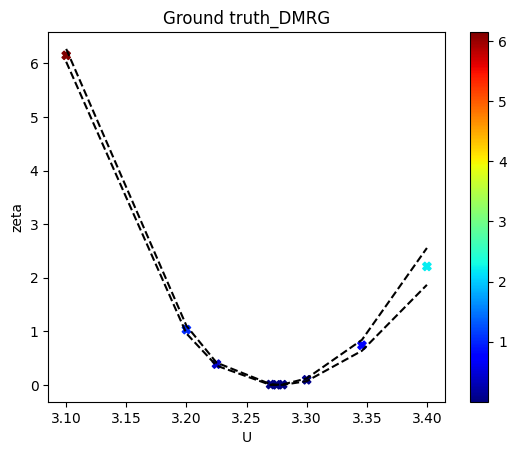

In [ ]:

a = plt.scatter(DMRG_data[:, 0], DMRG_data[:, 1], c=DMRG_data[:, 1], cmap="jet", marker="X")
plt.colorbar(a, orientation="vertical")
plt.plot(DMRG_data[:, 0], DMRG_data[:, 1]+DMRG_data[:, 2], "k--")
plt.plot(DMRG_data[:, 0], DMRG_data[:, 1]-DMRG_data[:, 2], "k--")
#plt.legend(loc="best")
#plt.xlim(3.125, 4)
plt.xlabel("U")
plt.ylabel("zeta")
plt.title("Ground truth_DMRG")

plt.show()

In [ ]:
lb = 3.1
ub = 3.4

bounds = np.array((lb, ub), dtype=float)
fidelities = np.array((1, 2))
x = np.linspace(lb, ub, 601)
x

array([3.1   , 3.1005, 3.101 , 3.1015, 3.102 , 3.1025, 3.103 , 3.1035,
       3.104 , 3.1045, 3.105 , 3.1055, 3.106 , 3.1065, 3.107 , 3.1075,
       3.108 , 3.1085, 3.109 , 3.1095, 3.11  , 3.1105, 3.111 , 3.1115,
       3.112 , 3.1125, 3.113 , 3.1135, 3.114 , 3.1145, 3.115 , 3.1155,
       3.116 , 3.1165, 3.117 , 3.1175, 3.118 , 3.1185, 3.119 , 3.1195,
       3.12  , 3.1205, 3.121 , 3.1215, 3.122 , 3.1225, 3.123 , 3.1235,
       3.124 , 3.1245, 3.125 , 3.1255, 3.126 , 3.1265, 3.127 , 3.1275,
       3.128 , 3.1285, 3.129 , 3.1295, 3.13  , 3.1305, 3.131 , 3.1315,
       3.132 , 3.1325, 3.133 , 3.1335, 3.134 , 3.1345, 3.135 , 3.1355,
       3.136 , 3.1365, 3.137 , 3.1375, 3.138 , 3.1385, 3.139 , 3.1395,
       3.14  , 3.1405, 3.141 , 3.1415, 3.142 , 3.1425, 3.143 , 3.1435,
       3.144 , 3.1445, 3.145 , 3.1455, 3.146 , 3.1465, 3.147 , 3.1475,
       3.148 , 3.1485, 3.149 , 3.1495, 3.15  , 3.1505, 3.151 , 3.1515,
       3.152 , 3.1525, 3.153 , 3.1535, 3.154 , 3.1545, 3.155 , 3.1555,
      

In [ ]:
X_test =x

In [ ]:
idx =[] # This is where you will save the index number from test data which has been evaluated, so we discard from the BO to consider for re-evaluation
for i in range(0, DMRG_data.shape[0]):
    id = np.argwhere(X_test==DMRG_data[i, 0])
    idx = np.append(idx, id)
idx  = idx.astype(int)
idx

array([  0, 200, 250, 340, 350, 360, 400, 492, 600])

In [ ]:
def kernel_prior() -> Dict[str, jnp.ndarray]:
    length = numpyro.sample("k_length", numpyro.distributions.HalfNormal(1))
    scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    return {"k_length": length, "k_scale": scale}


# Lets remove few sampes samples and train the GP

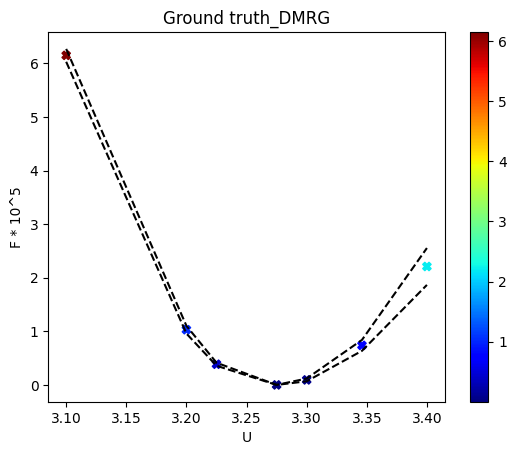

In [ ]:
DMRG_data_short = DMRG_data[[0, 1, 2,4, -3,-2,-1], :]
a = plt.scatter(DMRG_data_short[:, 0], DMRG_data_short[:, 1], c=DMRG_data_short[:, 1], cmap="jet", marker="X")
plt.colorbar(a, orientation="vertical")
plt.plot(DMRG_data_short[:, 0], DMRG_data_short[:, 1]+DMRG_data_short[:, 2], "k--")
plt.plot(DMRG_data_short[:, 0], DMRG_data_short[:, 1]-DMRG_data_short[:, 2], "k--")
#plt.legend(loc="best")
#plt.xlim(3.125, 4)
plt.xlabel("U")
plt.ylabel("F * 10^5")
plt.title("Ground truth_DMRG")

plt.show()

In [ ]:
idx =[] # This is where you will save the index number from test data which has been evaluated, so we discard from the BO to consider for re-evaluation
for i in range(0, DMRG_data_short.shape[0]):
    id = np.argwhere(X_test==DMRG_data_short[i, 0])
    idx = np.append(idx, id)
idx  = idx.astype(int)
idx

array([  0, 200, 250, 350, 400, 492, 600])

/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:03<00:00, 315.65it/s, 3 steps of size 4.02e-01. acc. prob=0.94]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.10      0.01      0.10      0.08      0.11    145.21      1.02
   k_scale      8.42      4.12      7.43      3.53     14.03    158.18      1.01
     noise      0.00      0.00      0.00      0.00      0.00    294.10      1.00



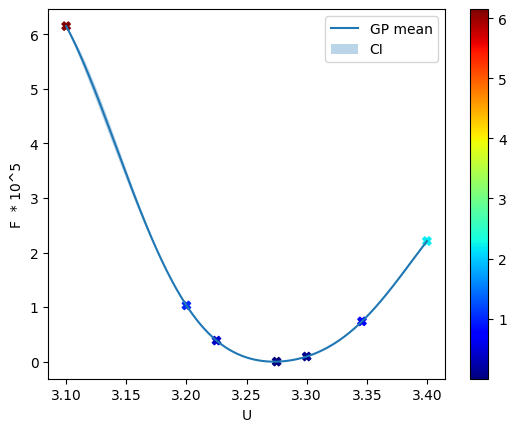

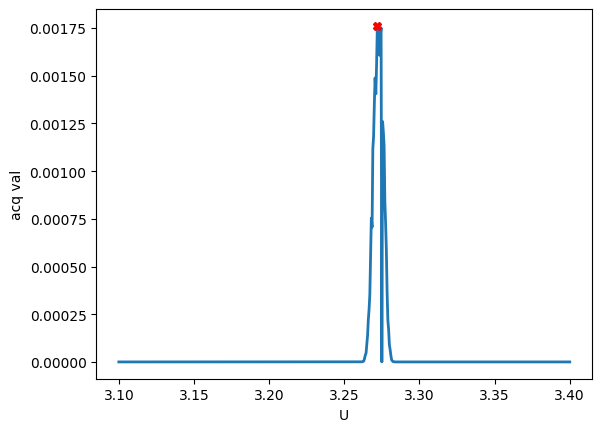

Next point: 3.272


In [ ]:

train_x = DMRG_data_short[:, 0]
train_y = DMRG_data_short[:, 1]

train_y_norm = (train_y - np.min(train_y))/(np.max(train_y) - np.min(train_y))


# Get random number generator keys for training and prediction
#random.seed(1)
rng_key, rng_key_predict = gpax.utils.get_keys(0)


# Initialize MF model
gp_model = gpax.ExactGP(1, kernel='RBF',kernel_prior=kernel_prior, noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(1*10e-6)))

# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model.fit(rng_key, train_x, train_y, num_warmup=500, num_samples=500, num_chains=1)


y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, noiseless=False)

pred_lower = y_pred - y_sampled.std(axis=(0,1))
pred_upper = y_pred + y_sampled.std(axis=(0,1))
plt.plot(X_test, y_pred, label="GP mean")
plt.fill_between(
    X_test.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="CI",
)
a = plt.scatter(train_x, train_y, c=train_y, cmap="jet", marker="X")
plt.colorbar(a, orientation="vertical")
#plt.xlim(0, 50)
plt.legend(loc="best")
plt.xlabel("U")
plt.ylabel("F  * 10^5")
plt.show()

# Compute the EI acq function
acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=False, noiseless=False)
acq = np.array(acq)
acq[idx] = 0
next_point_val = acq.max()
next_point_idx = acq.argmax()
idx = np.hstack((idx, next_point_idx))

#Plot acquistion function
plt.plot(X_test, acq, linewidth=2)
plt.plot(X_test[next_point_idx], acq[next_point_idx], c="r", marker="X")
plt.xlabel("U")
plt.ylabel("acq val")
plt.show()

if next_point_val == 0:
    print("Model sufficiently learned")
else:
    print("Next point: "+str(X_test[next_point_idx]))




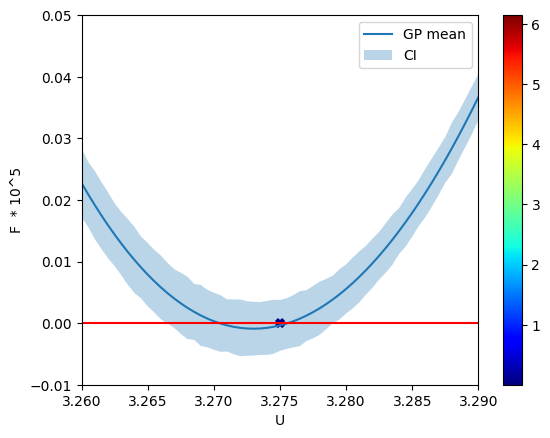

In [ ]:
pred_lower = y_pred - y_sampled.std(axis=(0,1))
pred_upper = y_pred + y_sampled.std(axis=(0,1))
plt.plot(X_test, y_pred, label="GP mean")
plt.fill_between(
    X_test.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="CI",
)
a = plt.scatter(train_x, train_y, c=train_y, cmap="jet", marker="X")
plt.colorbar(a, orientation="vertical")
plt.xlim(3.26, 3.29)
plt.ylim(-0.01, 0.05)
plt.legend(loc="best")
plt.xlabel("U")
plt.ylabel("F  * 10^5")

plt.axhline(y=0, color='r', linestyle='-')
plt.show()


Human Intervention: Replacing sample $U=3.27$ instead of $U=3.225$ for avoid negative estimation at near optimal region

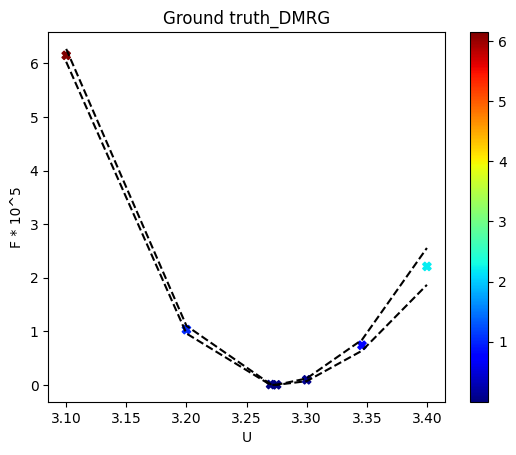

In [ ]:
DMRG_data_short = DMRG_data[[0, 1, 3, 4, -3,-2,-1], :]
a = plt.scatter(DMRG_data_short[:, 0], DMRG_data_short[:, 1], c=DMRG_data_short[:, 1], cmap="jet", marker="X")
plt.colorbar(a, orientation="vertical")
plt.plot(DMRG_data_short[:, 0], DMRG_data_short[:, 1]+DMRG_data_short[:, 2], "k--")
plt.plot(DMRG_data_short[:, 0], DMRG_data_short[:, 1]-DMRG_data_short[:, 2], "k--")
#plt.legend(loc="best")
#plt.xlim(3.125, 4)
plt.xlabel("U")
plt.ylabel("F * 10^5")
plt.title("Ground truth_DMRG")

plt.show()

In [ ]:
idx =[] # This is where you will save the index number from test data which has been evaluated, so we discard from the BO to consider for re-evaluation
for i in range(0, DMRG_data_short.shape[0]):
    id = np.argwhere(X_test==DMRG_data_short[i, 0])
    idx = np.append(idx, id)
idx  = idx.astype(int)
idx

array([  0, 200, 340, 350, 400, 492, 600])

/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:03<00:00, 307.67it/s, 15 steps of size 2.94e-01. acc. prob=0.95]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.18      0.06      0.18      0.09      0.28    119.37      1.02
   k_scale     12.43      8.46     10.18      3.18     23.13    138.76      1.02
     noise      0.00      0.00      0.00      0.00      0.00    363.67      1.00



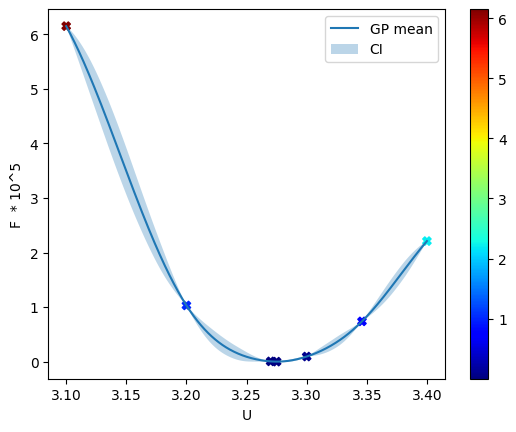

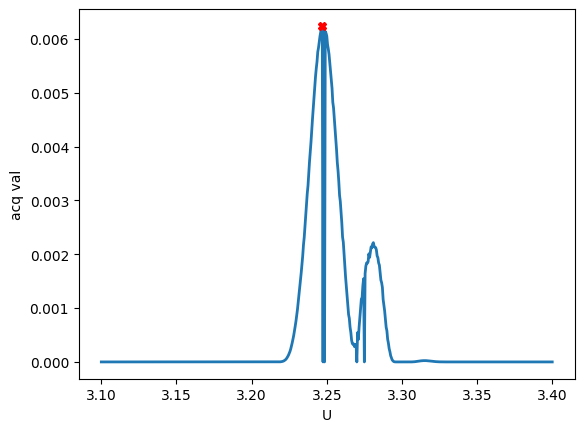

Next point: 3.2465


In [ ]:

train_x = DMRG_data_short[:, 0]
train_y = DMRG_data_short[:, 1]

train_y_norm = (train_y - np.min(train_y))/(np.max(train_y) - np.min(train_y))


# Get random number generator keys for training and prediction
#random.seed(1)
rng_key, rng_key_predict = gpax.utils.get_keys(0)


# Initialize MF model
gp_model = gpax.ExactGP(1, kernel='Matern',kernel_prior=kernel_prior, noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(1*10e-6)))

# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model.fit(rng_key, train_x, train_y, num_warmup=500, num_samples=500, num_chains=1)


y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, noiseless=False)

pred_lower = y_pred - y_sampled.std(axis=(0,1))
pred_upper = y_pred + y_sampled.std(axis=(0,1))
plt.plot(X_test, y_pred, label="GP mean")
plt.fill_between(
    X_test.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="CI",
)
a = plt.scatter(train_x, train_y, c=train_y, cmap="jet", marker="X")
plt.colorbar(a, orientation="vertical")
#plt.xlim(0, 50)
plt.legend(loc="best")
plt.xlabel("U")
plt.ylabel("F  * 10^5")
plt.show()

# Compute the EI acq function
acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=False, noiseless=False)
acq = np.array(acq)
acq[idx] = 0
next_point_val = acq.max()
next_point_idx = acq.argmax()
idx = np.hstack((idx, next_point_idx))

#Plot acquistion function
plt.plot(X_test, acq, linewidth=2)
plt.plot(X_test[next_point_idx], acq[next_point_idx], c="r", marker="X")
plt.xlabel("U")
plt.ylabel("acq val")
plt.show()

if next_point_val == 0:
    print("Model sufficiently learned")
else:
    print("Next point: "+str(X_test[next_point_idx]))




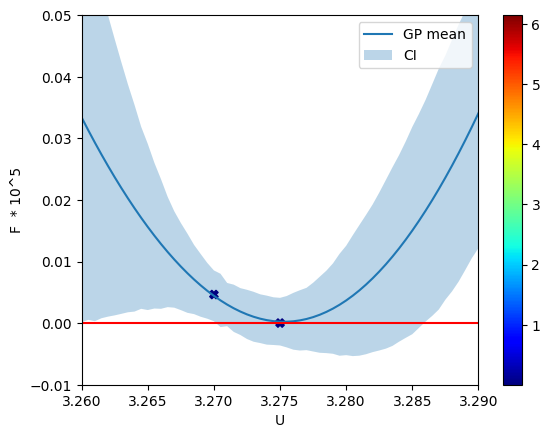

In [ ]:
pred_lower = y_pred - y_sampled.std(axis=(0,1))
pred_upper = y_pred + y_sampled.std(axis=(0,1))
plt.plot(X_test, y_pred, label="GP mean")
plt.fill_between(
    X_test.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="CI",
)
a = plt.scatter(train_x, train_y, c=train_y, cmap="jet", marker="X")
plt.colorbar(a, orientation="vertical")
plt.xlim(3.26, 3.29)
plt.ylim(-0.01, 0.05)
plt.legend(loc="best")
plt.xlabel("U")
plt.ylabel("F  * 10^5")

plt.axhline(y=0, color='r', linestyle='-')
plt.show()


With human knowledge we choose better sample for improved estimation, however the uncertanity is still very high. Thus, we fit with a structured GP which contains the physical information of the unknown function (convex) in a probabilistic model

# Structured GP

In [ ]:
# Defining the probabilistic model
@jit
def mean_func(x, params):

    x_data = x[:,0]

    f = params["a"]*jnp.exp((-1/2)*(jnp.square(x_data-params["b"])/jnp.square(params["c"])))
    f = jnp.absolute(params["d"]-f)+(1-jnp.sign((params["d"]-f)))

    return  f


def mf_priors():
    a = numpyro.sample("a", numpyro.distributions.HalfNormal(6)) #Height of peak
    b = numpyro.sample("b", numpyro.distributions.Uniform(3.26,3.29)) #Position of peak
    c = numpyro.sample("c", numpyro.distributions.HalfNormal(4)) #Broadness of peak
    d = numpyro.sample("d", numpyro.distributions.HalfNormal(6.15)) #Shift of the peak in y axis
    return {"a": a, "b": b, "c": c, "d": d}

/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:109: FutureWarning: `noise_prior` is deprecated and will be removed in a future version. Please use `noise_prior_dist` instead, which accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.HalfNormal(scale=0.1)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gpax/models/gp.py:117: UserWarning: `kernel_prior` will remain available for complex priors. However, for modifying only the lengthscales, it is recommended to use `lengthscale_prior_dist` instead. `lengthscale_prior_dist` accepts an instance of a numpyro.distributions Distribution object, e.g., `dist.Gamma(2, 5)`, rather than a function that calls `numpyro.sample`.
  warnings.warn(
sample: 100%|██████████| 1000/1000 [00:04<00:00, 227.75it/s, 3 steps of size 3.58e-01. acc. prob=0.76]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      5.16      3.04      5.03      0.66     10.20     22.07      1.08
         b      3.27      0.01      3.27      3.26      3.29    121.19      1.00
         c      2.44      2.58      1.73      0.09      6.44     20.55      1.00
         d      5.69      3.47      5.73      0.08     10.50     14.99      1.05
  k_length      0.18      0.06      0.17      0.10      0.28    200.83      1.01
   k_scale      7.79      8.27      5.60      0.70     15.73     35.79      1.02
     noise      0.00      0.00      0.00      0.00      0.00    113.65      1.01



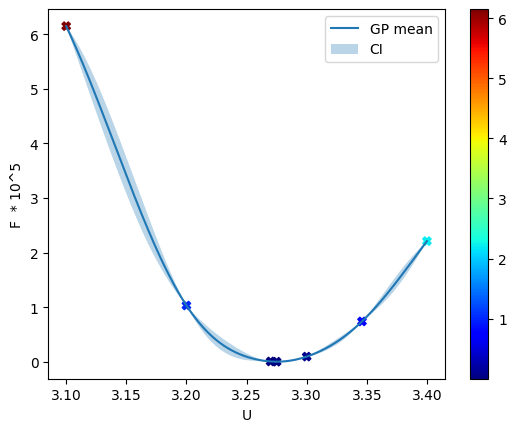

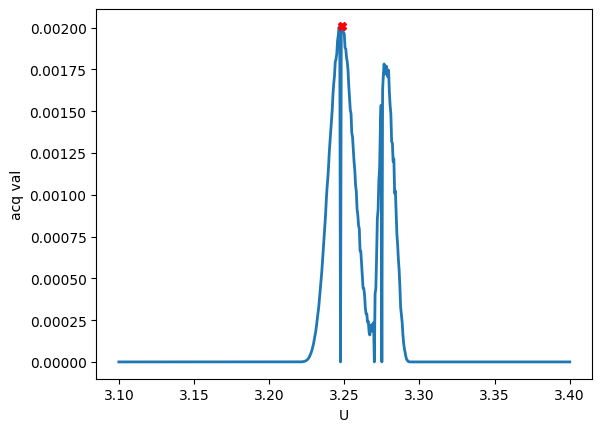

Next point: 3.2485


In [ ]:

train_x = DMRG_data_short[:, 0]
train_y = DMRG_data_short[:, 1]

train_y_norm = (train_y - np.min(train_y))/(np.max(train_y) - np.min(train_y))


# Get random number generator keys for training and prediction
#random.seed(1)
rng_key, rng_key_predict = gpax.utils.get_keys(0)


# Initialize MF model
gp_model = gpax.ExactGP(1, kernel='Matern',kernel_prior=kernel_prior, mean_fn=mean_func, mean_fn_prior=mf_priors,
                        noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(1*10e-6)))

# Run Hamiltonian Monte Carlo to obtain posterior samples for kernel parameters and model noise
gp_model.fit(rng_key, train_x, train_y, num_warmup=500, num_samples=500, num_chains=1)


y_pred, y_sampled = gp_model.predict(rng_key_predict, X_test, noiseless=False)


pred_lower = y_pred - y_sampled.std(axis=(0,1))
pred_upper = y_pred + y_sampled.std(axis=(0,1))
plt.plot(X_test, y_pred, label="GP mean")
plt.fill_between(
    X_test.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="CI",
)
a = plt.scatter(train_x, train_y, c=train_y, cmap="jet", marker="X")
plt.colorbar(a, orientation="vertical")
#plt.xlim(0, 50)
plt.legend(loc="best")
plt.xlabel("U")
plt.ylabel("F  * 10^5")
plt.show()

# Compute the EI acq function
acq = gpax.acquisition.EI(rng_key_predict, gp_model, X_test, maximize=False, noiseless=False)
acq = np.array(acq)
acq[idx] = 0
next_point_val = acq.max()
next_point_idx = acq.argmax()
idx = np.hstack((idx, next_point_idx))

#Plot acquistion function
plt.plot(X_test, acq, linewidth=2)
plt.plot(X_test[next_point_idx], acq[next_point_idx], c="r", marker="X")
plt.xlabel("U")
plt.ylabel("acq val")
plt.show()

if next_point_val == 0:
    print("Model sufficiently learned")
else:
    print("Next point: "+str(X_test[next_point_idx]))




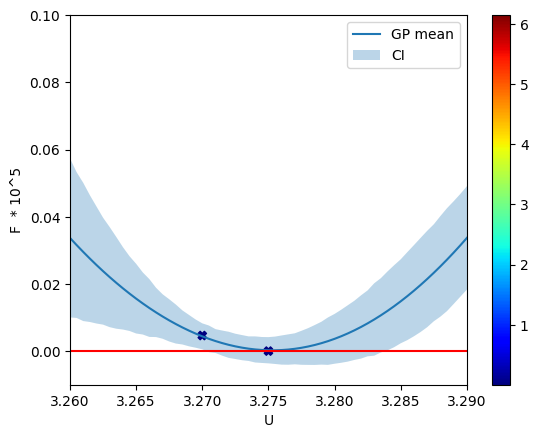

In [ ]:
pred_lower = y_pred - y_sampled.std(axis=(0,1))
pred_upper = y_pred + y_sampled.std(axis=(0,1))
plt.plot(X_test, y_pred, label="GP mean")
plt.fill_between(
    X_test.flatten(),
    pred_lower,
    pred_upper,
    alpha=0.3,
    label="CI",
)
a = plt.scatter(train_x, train_y, c=train_y, cmap="jet", marker="X")
plt.colorbar(a, orientation="vertical")
plt.xlim(3.26, 3.29)
plt.ylim(-0.01, 0.1)
plt.legend(loc="best")
plt.xlabel("U")
plt.ylabel("F  * 10^5")


plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [ ]:
np.min(y_pred),np.argmin(y_pred),np.min(y_sampled.std(axis=(0,1))),np.max(y_sampled.std(axis=(0,1)))

(Array(0.00022876, dtype=float64),
 Array(351, dtype=int64),
 Array(0.00350964, dtype=float64),
 Array(0.43790106, dtype=float64))

In [ ]:
X_test[np.argmin(y_pred)]

3.2755

In [ ]:
X_test.shape, y_pred.shape, y_sampled.std(axis=(0,1)).shape
GP_Data = np.vstack((X_test, y_pred, y_sampled.std(axis=(0,1))))
GP_Data = GP_Data.T
GP_Data.shape
np.min(GP_Data[:, 0]), np.min(GP_Data[:, 1]), np.min(GP_Data[:, 2])

(3.1, 0.00025347805626271146, 0.0035519071625483714)

In [ ]:
np.savetxt("sGP_Data.txt", GP_Data, delimiter=",")

In [ ]:
np.savetxt("sGP_Data.csv", GP_Data, delimiter=",")